# TRABAJO PRÁCTICO 5 - ÁRBOLES DE DECISIÓN

In [1]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# A) EXPLORACIÓN DE DATOS

In [2]:
dataset = fetch_ucirepo(id=697)

x_original = dataset.data.features
y_original = dataset.data.targets

differents = set(y_original['Target'])
# print(differents)

#--------------------------------------------------------- Adaptación a clasificación binaria

y = np.where(y_original['Target'] == 'Graduate', 1, 0)

#--------------------------------------------------------- Separación de ordinales y nominales

list_nominal_features = ['Marital Status', 'Application mode','Course', 'Daytime/evening attendance',
            'Nacionality', "Mother's occupation", "Father's occupation", 'Displaced',
            'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender',
            'Scholarship holder', 'International'
            ] 

nominal_features = x_original[list_nominal_features]
ordinal_features = x_original.drop(columns = list_nominal_features)

#--------------------------------------------------------- Codificación One-Hot y preparación de datos

#Se coloca 'if_binary' para que concatene las binarias en 1 columna unicamente y no separe en 2
encoder_nominal = OneHotEncoder(sparse_output=False, drop = 'if_binary')

#Se obtienen las nominales codificadas en un array
nominal_encoded = encoder_nominal.fit_transform(nominal_features) 

#Se obtienen las etiquetas de las nominales
nominal_columns = encoder_nominal.get_feature_names_out(nominal_features .columns)

#Se vuelve al formato DataFrame de los features nominales, con las etiquetas incluidas
nominal_features = pd.DataFrame(nominal_encoded, columns=nominal_columns)

# print('Features de las nominales:',nominal_features.columns)
# print('Features de las ordinales',ordinal_features.columns)

#Se concatenan los features ordinales y nominales
x = pd.concat([ordinal_features,nominal_features], axis=  1)

#--------------------------------------------------------- Separación de datos en train y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=509, stratify=y)


# print('ordinales:',ordinal_features.shape)
# print('nominales:',nominal_encoded.shape)
# print('x:',x.shape)
# print('x_train:',x_train.shape)
# print('x_test:',x_test.shape)
# print('y_train:',y_train.shape)
# print('y_test:',y_test.shape)


# x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train, columns = ['Class'])
# x_test = pd.DataFrame(x_test)
y_test = pd.DataFrame(y_test, columns = ['Class'])


# B) ÁRBOL DE DECISIÓN

### Entrenamiento y exploración del árbol

Condición del nodo raíz: Curricular units 2nd sem (approved) <= 4.500
Nodo 0: Feature = Curricular units 2nd sem (approved), Condición = Curricular units 2nd sem (approved) <= 4.500
Nodo 1: Feature = Curricular units 2nd sem (approved), Condición = Curricular units 2nd sem (approved) <= 3.500


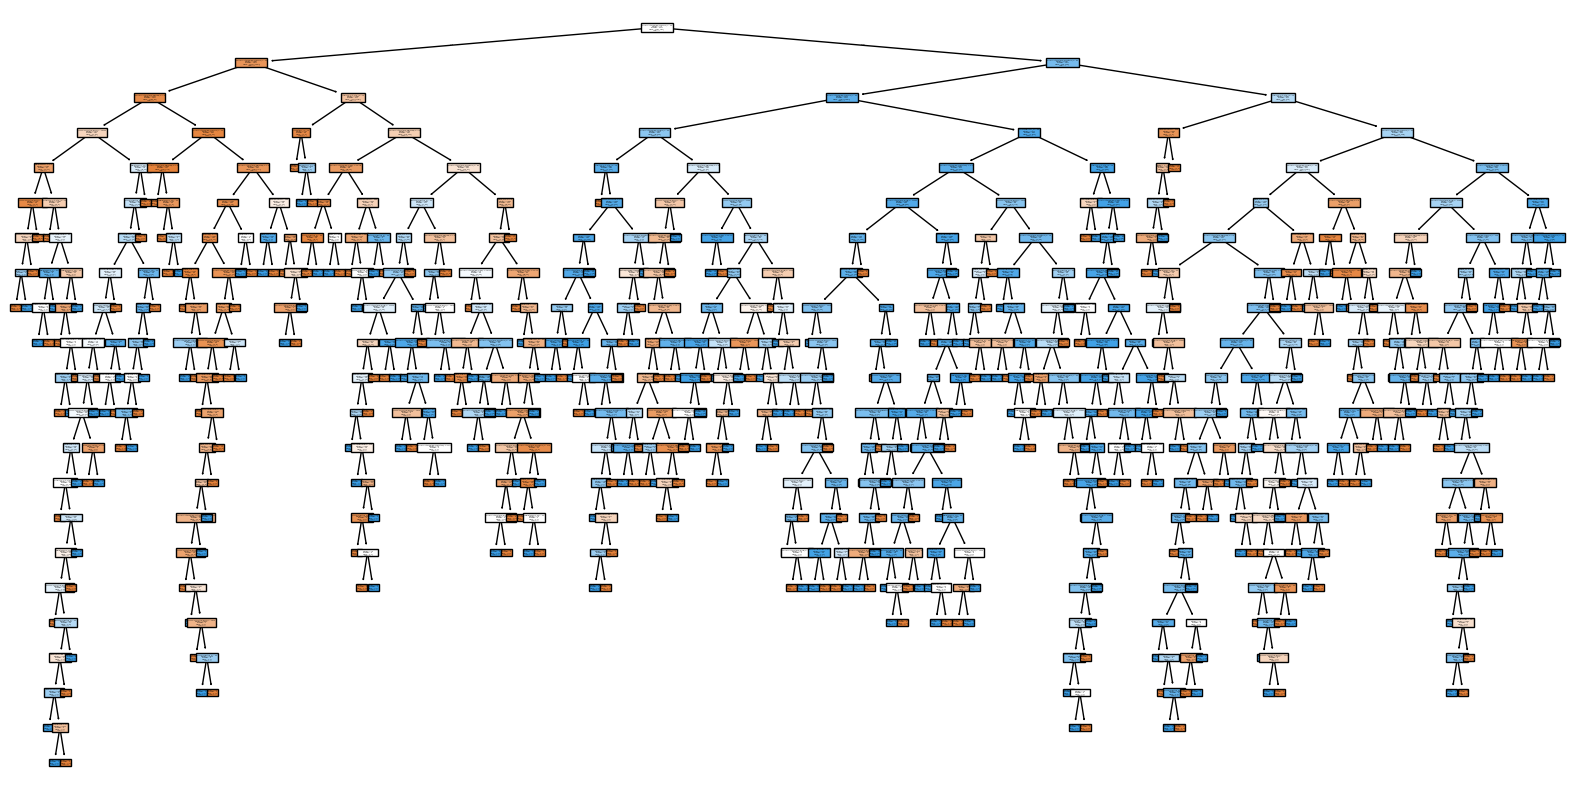

In [3]:
#--------------------------------------------------------- Entrenamiento 

model = DecisionTreeClassifier(criterion='entropy', random_state=509)
model.fit(x_train, y_train)

#--------------------------------------------------------- Se obtienen las condiciones del root y primeros nodos

#Se obtiene el feature que se utiliza como condición en el nodo raíz
root_feature = x_train.columns[model.tree_.feature[0]]

#Se obtiene el umbral de decisión del root
root_threshold = model.tree_.threshold[0]

print(f"Condición del nodo raíz: {root_feature} <= {root_threshold:.3f}") #Nodos a izquierda siempre son <= que el umbral


#Se imprimen los primeros 2 nodos
for i in range(2):
    feature = model.tree_.feature[i] #El feature de cada nodo
    threshold = model.tree_.threshold[i] #El umbral de cada nodo
    
    if feature != -2:  #Se seleccionan los nodos que no son hojas
        print(f"Nodo {i}: Feature = {x_train.columns[feature]}, Condición = {x_train.columns[feature]} <= {threshold:.3f}")

#--------------------------------------------------------- Gráfico del arbol completo

plt.figure(figsize=(20,10))
plot_tree(
    model, 
    feature_names=x_train.columns,         #Se obtienen los nombres de los features
    class_names=[str(c) for c in np.unique(y_train)],  #Se colocan los nombres de las clases
    filled=True,                     #Se colorea el nodo con la clase mayoritaria
)

plt.show()


### Testeo del árbol

In [4]:
#--------------------------------------------------------- Métricas
#Se realiza la predicción del modelo
y_pred = model.predict(x_test)

#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la macro-F1
f1 = f1_score(y_test, y_pred, average='macro')

#Se crea un dataframe con las Features Importance junto a cada feature, ordenados de forma descendiente
feature_importances = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

#Se imprimen las 2 features más importantes
mainly_features = feature_importances.head(2)

print('Accuracy: ', accuracy)
print('Macro-F1: ', f1)
print('Features más importantes: ', mainly_features)


Accuracy:  0.8019891500904159
Macro-F1:  0.8019889882156741
Features más importantes:                                  Feature  Importance
16  Curricular units 2nd sem (approved)    0.368691
5                       Admission grade    0.047892


Como puede observarse, el accuracy para el arbol sin podar, es del 80.2%
Es coincidente con el Macro-F1 que es el que calcula el promedio de los accuracy para cada clase.
El feature importance indica que 'Curricular units 2nd sem (approved)' es el más relevante con diferencia con respecto al resto, lo que indica que es muy determinante de cara a la clasificación de las muestras.


# C) PODADO

### Obtención de los $\alpha$ relevantes y elección del óptimo (según el accuracy máximo)

In [5]:
#--------------------------------------------------------- Obtención de los alpha relevantes para la poda del arbol

path = model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas = path.ccp_alphas      # Lista de los alpha

print(ccp_alphas.shape)

#--------------------------------------------------------- Se entrena con el alpha que maximiza el accuracy
index_alpha = 199
selected_alpha = ccp_alphas[index_alpha]

(214,)


### Repetición del inciso B para un nuevo valor de $\alpha$

##### Entrenamiento y exploración

Condición del nodo raíz: Curricular units 2nd sem (approved) <= 4.500
Nodo 1: Feature = Curricular units 2nd sem (approved), Condición = Curricular units 2nd sem (approved) <= 3.500
Nodo 2: Feature = Curricular units 1st sem (enrolled), Condición = Curricular units 1st sem (enrolled) <= 0.500
Nodo 3: Feature = Previous qualification (grade), Condición = Previous qualification (grade) <= 133.550


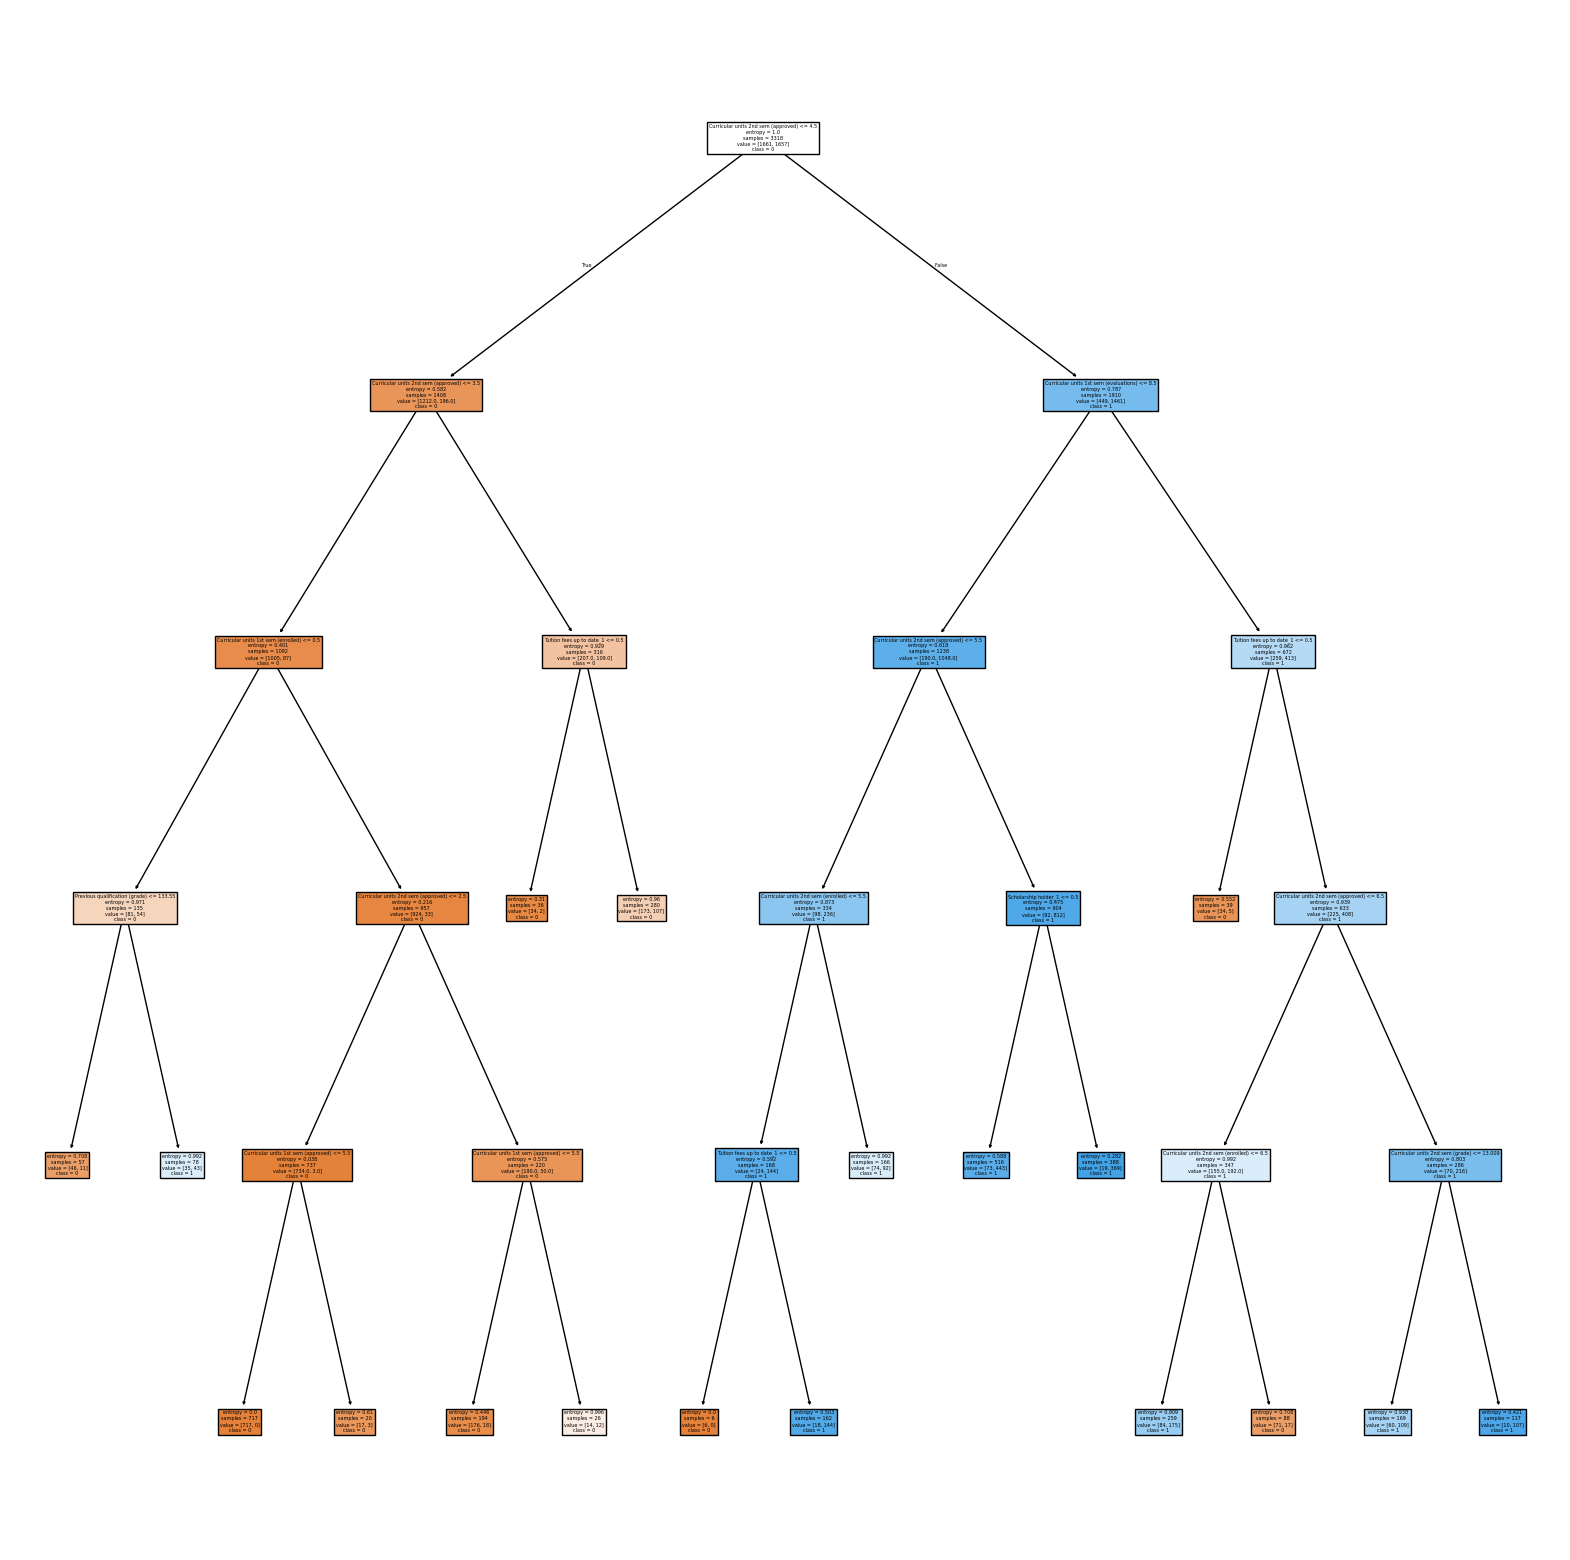

In [6]:
#--------------------------------------------------------- Entrenamiento 

new_model = DecisionTreeClassifier(criterion='entropy', random_state=509, ccp_alpha=selected_alpha)
new_model.fit(x_train, y_train)

#--------------------------------------------------------- Se obtienen las condiciones del root y primeros nodos

#Se obtiene el feature que se utiliza como condición en el nodo raíz
root_feature = x_train.columns[new_model.tree_.feature[0]]

#Se obtiene el umbral de decisión del root
root_threshold = new_model.tree_.threshold[0]

print(f"Condición del nodo raíz: {root_feature} <= {root_threshold:.3f}") #Nodos a izquierda siempre son <= que el umbral


#Se imprimen los primeros 5 nodos
for i in range(1,5):
    feature = new_model.tree_.feature[i] #El feature de cada nodo
    threshold = new_model.tree_.threshold[i] #El umbral de cada nodo
    
    if feature != -2:  #Se seleccionan los nodos que no son hojas
        print(f"Nodo {i}: Feature = {x_train.columns[feature]}, Condición = {x_train.columns[feature]} <= {threshold:.3f}")

#--------------------------------------------------------- Gráfico del arbol completo

plt.figure(figsize=(20,20))
plot_tree(
    new_model, 
    feature_names=x_train.columns,         #Se obtienen los nombres de los features
    class_names=[str(c) for c in np.unique(y_train)],  #Se colocan los nombres de las clases
    filled=True,                     #Se colorea el nodo con la clase mayoritaria
)

plt.show()


##### Testeo del árbol

In [7]:
#--------------------------------------------------------- Métricas
#Se realiza la predicción del modelo
y_pred = new_model.predict(x_test)

#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la macro-F1
f1 = f1_score(y_test, y_pred, average='macro')

#Se crea un dataframe con las Features Importance junto a cada feature, ordenados de forma descendiente
feature_importances = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': new_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

#Se imprimen las 2 features más importantes
mainly_features = feature_importances.head(2)

print('Accuracy: ', accuracy)
print('Macro-F1: ', f1)
print('Features más importantes: ', mainly_features)


Accuracy:  0.8372513562386981
Macro-F1:  0.8365587019273397
Features más importantes:                                  Feature  Importance
16  Curricular units 2nd sem (approved)    0.746550
8   Curricular units 1st sem (enrolled)    0.061961


Al realizar la poda según el alpha que maximiza el accuracy, este mejora y se mantiene a la par del Macro-F1

Nuevamente, el feature 'Curricular units 2nd sem (approved)' es el más relevante para la toma de decisiones y más que antes, ya que el valor de importancia es mayor que el previo.

### Gráficos en función del parámetro de complejidad $\alpha$

Alpha que maximiza el accuracy: 0.003843
ID: 199
Alpha que maximiza la Macro-F1: 0.003843
ID: 199


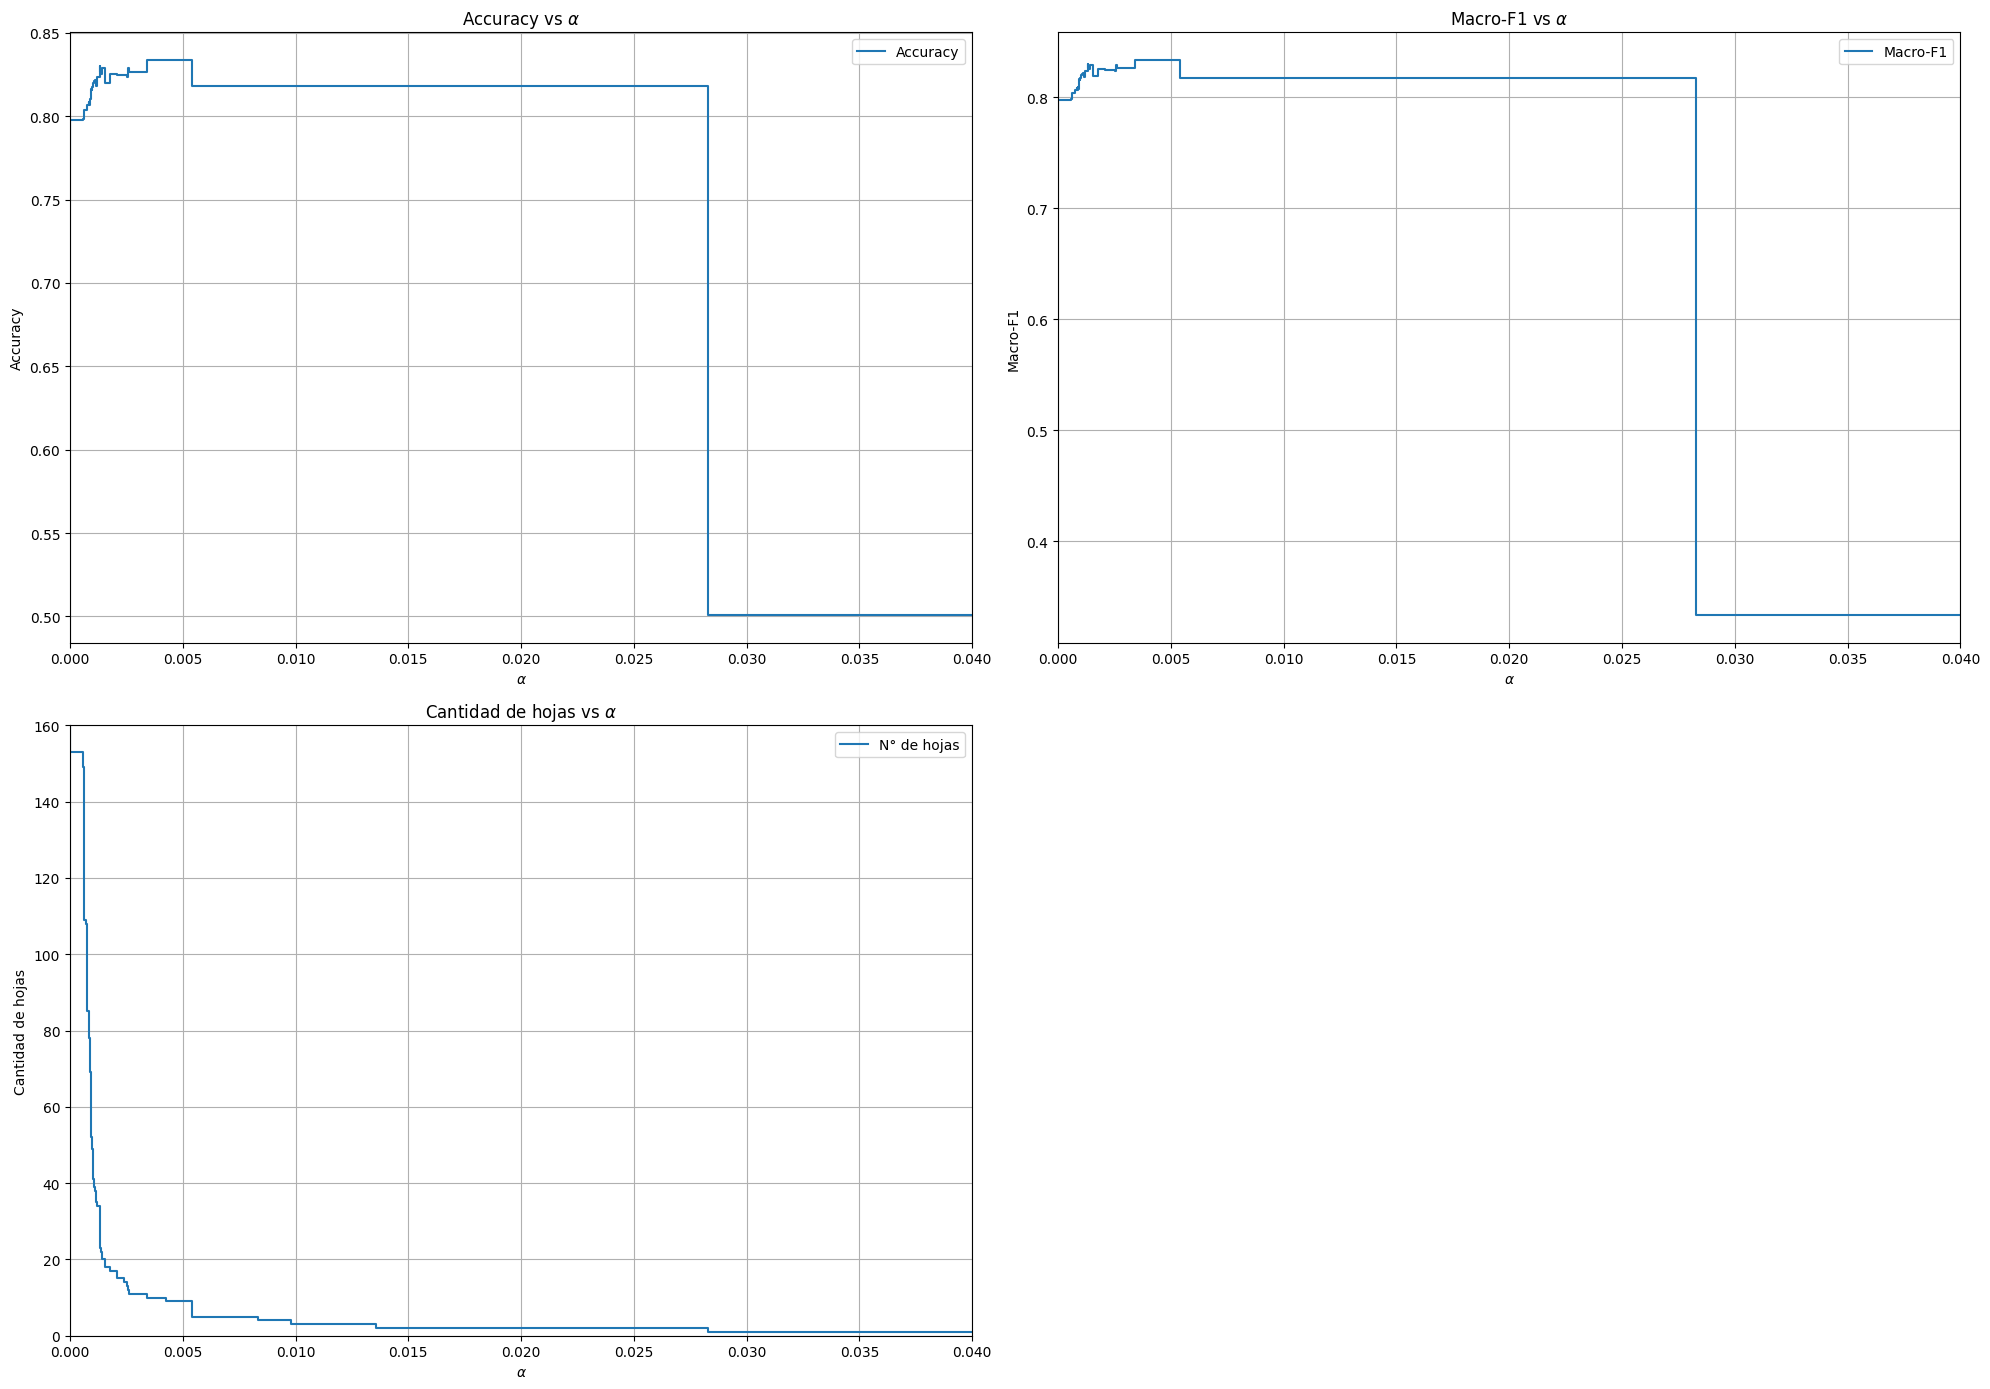

In [8]:
#--------------------------------------------------------- Entrenamiento y testeo para el array de alphas

#Se hace una list comprehension con el fin de entrenar el modelo para los alpha y cargarlos en una lista
models = [DecisionTreeClassifier(random_state=509, ccp_alpha=alpha).fit(x_train, y_train)
          for alpha in ccp_alphas]

#Se aplica una list comprehension con el fin de cargar los valores predichos por los modelos entrenados
y_preds = [model.predict(x_test) for model in models]

#Se aplica otra list comprehension con el fin de cargar la cantidad de hojas en una lista
leaves = [model.get_n_leaves() for model in models]

#Se aplica otra list comprehension con el fin de cargar los accuracy en una lista
accuracy_scores = [accuracy_score(y_test, y_pred) for y_pred in y_preds ]

#Se aplica otra list comprehension con el fin de cargar los Macro-F1 en una lista
f1_scores = [f1_score(y_test, y_pred, average='macro') for y_pred in y_preds]

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()  #Para facilitar la indexacion

# Grafico del accuracy
axes[0].step(ccp_alphas, accuracy_scores, label='Accuracy')
axes[0].set_title(r'Accuracy vs $\alpha$')
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlim(0, 0.04)
axes[0].legend()
axes[0].grid()

# Grafico de la Macro-F1
axes[1].step(ccp_alphas, f1_scores, label='Macro-F1')
axes[1].set_title(r'Macro-F1 vs $\alpha$')
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel('Macro-F1')
axes[1].set_xlim(0, 0.04)
axes[1].legend()
axes[1].grid()

# Grafico de la cantidad de hojas
axes[2].step(ccp_alphas, leaves, label='N° de hojas')
axes[2].set_title(r'Cantidad de hojas vs $\alpha$')
axes[2].set_xlabel(r'$\alpha$')
axes[2].set_ylabel('Cantidad de hojas')
axes[2].set_xlim(0, 0.04)
axes[2].set_ylim(0,160)
axes[2].legend()
axes[2].grid()

#Se deja vacio el ultimo grafico
axes[3].axis('off')  

plt.tight_layout()

#--------------------------------------------------------- Se obtiene el alpha que maximiza el accuracy y el del Macro-F1
id_max_accuracy = np.argmax(accuracy_scores) #Se extrae el índice
alpha_max_acc = ccp_alphas[id_max_accuracy]
print('Alpha que maximiza el accuracy:', round(alpha_max_acc, 6))
print('ID:', id_max_accuracy)

id_max_f1 = np.argmax(f1_scores) #Se extrae el índice
alpha_max_f1 = ccp_alphas[id_max_f1]
print('Alpha que maximiza la Macro-F1:',round(alpha_max_f1, 6))
print('ID:', id_max_f1)


En dichos gráficos se puede observar que los alpha en torno a 0.005 son los que maximizan el accuracy y a su vez tienen un buen número de hojas con respecto al árbol completo. Previamente se entrenó el arbol para este valor de alpha que maximiza el accuracy y se observó que inclusive al recortar hojas, mejora el accuracy y además se evita el overfitting

### Se indican los 2 features con mayor importancia para el árbol con mayor F1

In [9]:
#Se crea un dataframe con las Features Importance junto a cada feature, ordenados de forma descendiente
model_max_f1 = models[id_max_f1]
importances_max_f1 = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': model_max_f1.feature_importances_
}).sort_values(by='Importance', ascending=False)

#Se imprimen las 2 features más importantes
mainly_features_max_f1 = importances_max_f1.head(2)

print('Features más importantes: ', mainly_features_max_f1)

Features más importantes:                                     Feature  Importance
16     Curricular units 2nd sem (approved)    0.829381
9   Curricular units 1st sem (evaluations)    0.055539


Nuevamente el feature más relevante es 'Curricular units 2nd sem (approved)'

# D) BOSQUE ALEATORIO

### Entrenamiento y testeo del bosque

In [10]:
#Se crea el clasificador con 20 arboles
forest = RandomForestClassifier(n_estimators=20, criterion='entropy',random_state=509)

#Se entrena el modelo
forest.fit(x_train, y_train.to_numpy().ravel()) #Se aplana para evitar el warning

#Se realiza la predicción
y_pred = forest.predict(x_test)

#Se computa el accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#Se computa el Macro-F1
f1 = f1_score(y_test,y_pred)
print("Macro-F1:", f1)

Accuracy: 0.8471971066907775
Macro-F1: 0.8518843120070114


Al entrenar múltiples bosques, se puede observar una ligera mejora en el accuracy y el Macro-F1

### Se muestran los 2 features más relevantes según la Features Importance

In [11]:
#Se crea un dataframe con las Features Importance junto a cada feature, ordenados de forma descendiente
importances_forest = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': forest.feature_importances_
}).sort_values(by='Importance', ascending=False)

#Se imprimen las 2 features más importantes
mainly_features_forest = importances_forest.head(2)

print('Features más importantes en el bosque: ', mainly_features_forest)

Features más importantes en el bosque:                                  Feature  Importance
16  Curricular units 2nd sem (approved)    0.143915
10  Curricular units 1st sem (approved)    0.092408
